In [0]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from os import listdir
import random
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import random

import xml.etree.ElementTree as ET
import numpy as np
from scipy import misc
from PIL import Image
import glob
import imageio
import os

import matplotlib.pyplot as plt

from google.colab import files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class YOLO(nn.Module):
    """neural network architectur inspired by YOLO V1"""
    
    def __init__(self, img_width, row_size):
        super(YOLO, self).__init__()
        self.row_size = row_size
        self.conv1 = nn.Conv2d(1, 16, 7, stride=2)
        self.mp1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, (3, 3), stride=1)
        self.mp2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, (3, 3), stride=1)
        self.mp3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*53*36, 4096)
        self.fc2 = nn.Linear(4096, row_size * 5)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = self.mp3(x)
        x = x.view(-1, 64*53*36)
        x = F.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        x = x.view(-1, self.row_size, 5)
        x = torch.sigmoid(x)
        return x

In [0]:
def create_data(row_size, batch_size, transform, imgs_path, xmls_path):
    """create data for training/validation from img and xml to tensor"""
    
    data_list = []
    target_list = []
    data = []

    imgs = os.listdir(imgs_path)
    imgs.sort()
    xmls = os.listdir(xmls_path)
    xmls.sort()

    for i in range(len(imgs)):
        line_count = 1
        img = Image.open(imgs_path + imgs[i])
        img_tensor = transform(img)
        data_list.append((img_tensor))
        row_height = img_tensor.size(1) / row_size
        row_width = img_tensor.size(2)

        tree = ET.parse(xmls_path + xmls[i])
        root = tree.getroot()

        target = [[0, 0, 0, 0, 0] for i in range(row_size)]

        for line in root[1]:  # root[1] catches handwritten part
            x1 = 999999999999999
            y1 = 999999999999999
            y2 = 0
            width = 0
            for word in line:
                if (word.tag == "word"):  # there isn't only words lines
                    for char in word:
                        x1 = min(x1,int(char.attrib["x"]) * percent / 100)
                        y1 = min(y1,int(char.attrib["y"]) * percent / 100)
                        y2 = max(y2,(int(char.attrib["y"]) + int(char.attrib["height"])) * percent / 100)
                        width = int(char.attrib["x"]) * percent / 100 - x1 + int(char.attrib["width"]) * percent / 100

            x2 = x1 + width

            line_count += 1

            b_x = x1/2 + x2/2
            b_y = y1/2 + y2/2
            b_w = x2-x1
            b_h = y2-y1

            if(b_h < 0):
                print(y1,y2,b_h)
            
            row = int(b_y // row_height)

            b_box = [1, b_x / row_width, (b_y % row_height) / row_height, b_w / row_width,
                     (b_h / img_tensor.size(1))] 
            target[row] = b_box

        del(root)
        del(tree)
        del(img)
        del(img_tensor)
        target = torch.FloatTensor(target)
        target_list.append(target)
        del(target)
        if len(data_list) >= batch_size:
            data.append((torch.stack(data_list), torch.stack(target_list)))
            del(data_list)
            del(target_list)
            data_list = []
            target_list = []
            print('Loaded batch ', len(data), 'of ', int(len(listdir(imgs_path)) / batch_size))
            print('Percentage Done: ',
                  100 * (len(data)) / int(len(listdir(imgs_path)) / batch_size), '%')

    return data

In [0]:
def train(train_data, model, optimizer, device):
    """
    Trains/updates the model for one epoch on the training dataset.

    Parameters:
        train_data (torch tensor): The trainset
        model (torch.nn.module): Model to be trained
        optimizer (torch.optim.optimizer): optimizer instance like SGD or Adam
        device (string): cuda or cpu
    """

    # switch to train mode
    model.train()

    # iterate through the dataset loader
    i = 0
    losses = []
    for (inp, target) in train_data:
        # transfer inputs and targets to the GPU (if it is available)
        inp = inp.to(device)
        target = target.to(device)

        # compute output, i.e. the model forward
        output = model(inp)

        # print("output", output.size(), "target", target.size())
        # calculate the loss

        loss = yolo_loss(output, target)
        #print("loss", loss)
        if (i == 0):
            print(output[0])
            print(target[0])
        i += 1
        iou = calc_mean_iou(output, target)
        print("loss {:.2} IOU {:.2}".format(loss,iou))
        ious.append(iou)

        # compute gradient and do the SGD step
        # we reset the optimizer with zero_grad to "flush" former gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [0]:
def validate(val_dataset, model, device, treshold, percent):
    model.eval()

    # avoid computation of gradients and necessary storing of intermediate layer activations
    with torch.no_grad():
        # iterate through the dataset loader
        losses = []
        ious = []
        accs = []
        precs = []
        recs = []

        for (inp, target) in val_dataset:
            # transfer to device
            inp = inp.to(device)
            target = target.to(device)

            # compute output
            output = model(inp)

            # find right boxes
            non_maximum_suppression(output, percent)

            # compute loss
            loss = yolo_loss(output, target)
            iou = calc_mean_iou(output, target)
            acc = calc_accuracy(output, target, treshold)
            prec = calc_precision(output, target, treshold)
            rec = calc_recall(output, target, treshold) 

            losses.append(loss)
            ious.append(iou)
            accs.append(acc)
            precs.append(prec)
            recs.append(rec)

            print("loss {:.2} IOU {:.2}".format(loss,iou))
    avg_loss = torch.mean(torch.stack(losses)).item()
    avg_iou = torch.mean(torch.stack(ious)).item()
    avg_acc = sum(accs) / len(accs)
    avg_prec = sum(precs) / len(precs)
    avg_rec = sum(recs) / len(recs)
    print("avg. loss {:.2} avg. IOU {:.2} avg. acc {:.2} avg. prec {:.2} avg. rec {:.2}".format(avg_loss, avg_iou, avg_acc, avg_prec, avg_rec))

    return [avg_loss, avg_iou, avg_acc, avg_prec, avg_rec]


In [0]:
def yolo_loss(output, target):
    """calculate loss from output with target"""

    lambda_coord = 5
    lambda_noob = 0.5
    errors = []
    for i in range(output.size(0)):
        error1 = 0
        error2 = 0
        error3 = 0
        error4 = 0
        for j in range(output.size(1)):
            if (target[i][j][0] == 1.0):
                #print(target[i][j][1])
                #print(target[1])
                error1 += (target[i][j][1] - output[i][j][1]) ** 2 + (target[i][j][2] - output[i][j][2]) ** 2
                error2 += (target[i][j][3].sqrt() - output[i][j][3].sqrt()) ** 2 +  (target[i][j][4].sqrt() - output[i][j][4].sqrt()) ** 2 
                error3 += (target[i][j][0] - output[i][j][0]) ** 2
            else: 
                error4 += (target[i][j][0] - output[i][j][0]) ** 2
        error = lambda_coord * error1 + lambda_coord * error2 + error3 + lambda_noob * error4
        errors.append(error)
    return torch.mean(torch.stack(errors))


In [0]:
def calc_iou(box1, box2):
    """calculate iou for 2 boxes"""
    
    # calculate the coordinates of the insersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # calculate the area of intersetion rectangle
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    # calculate the area of the single boxes
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = intersection / (box1_area + box2_area - intersection)

    return iou


In [0]:
def calc_x_y(row, tensor):
    """calculate x, y, width, height from output """
    
    x = tensor[1] * 619
    y = tensor[2] * (885 / 50) + row * (885 / 50)
    width = tensor[3] * 619
    #height = (tensor[4] / 10) * 885
    height = tensor[4] * 885
    return torch.FloatTensor([1, x, y, width, height])


In [0]:
def calc_mean_iou(output, target):
    """calculate iou for batch """
    
    iou_list = []
    for i in range(output.size(0)):
        ious = []
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                x_y_target = calc_x_y(j, target[i, j])
                x_y_output = calc_x_y(j, output[i, j])
                box1 = calc_box(x_y_target)
                box2 = calc_box(x_y_output)
                ious.append(calc_iou(box1, box2))
        iou_list.append(torch.mean(torch.stack(ious)))

    mean_iou = torch.mean(torch.stack(iou_list))
    return mean_iou

In [0]:
def calc_box(tensor):
    """calculate coordinates for the output image from tensor"""
    x1 = max(0, tensor[1] - 0.5 * tensor[3])
    y1 = max(0, tensor[2] - 0.5 * tensor[4])
    x2 = min(619, tensor[1] + 0.5 * tensor[3])
    y2 = min(885, tensor[2] + 0.5 * tensor[4])

    box = [x1, y1, x2, y2]
    return box


In [0]:
def calc_accuracy(output, target, percent):
    """calculate accuracy for a batch, by percent as treshold"""
    acc_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                acc_list.append(1 if (output[i][j][0] >= percent) else 0)
            else:
                acc_list.append(1 if (output[i][j][0] < percent) else 0)
    acc = sum(acc_list) / len(acc_list) if(sum(acc_list) > 0) else 0 
    return acc 

In [0]:
def calc_precision(output, target, percent):
    """calculate precision for a batch, by percent as treshold"""

    prec_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (output[i][j][0] >= percent):
                prec_list.append(1 if (target[i][j][0] == 1) else 0)
    prec = sum(prec_list) / len(prec_list) if(sum(prec_list) > 0) else 0     
    return sum(prec_list) / len(prec_list)


In [0]:
def calc_recall(output, target, percent):
    """calculate recall for a batch, by percent as treshold"""
    
    rec_list = []
    for i in range(output.size(0)):
        for j in range(output.size(1)):
            if (target[i][j][0] == 1):
                rec_list.append(1 if (output[i][j][0] >= percent) else 0)
    
    rec = sum(rec_list) / len(rec_list) if(sum(rec_list) > 0) else 0 
    return rec

In [0]:
imgs_train_path = 'drive/My Drive/data_small/forms/forms_train_small/'
xmls_train_path = 'drive/My Drive/data_small/xmls/xml_train/'
imgs_test_path = 'drive/My Drive/data_small/forms/forms_test_small/'
xmls_test_path = 'drive/My Drive/data_small/xmls/xml_test/'

weight_path = "C:/Users/Pasca/Documents/Goethe-Uni/Master_1.Semester/Pattern_Analyis_Machine_Intelligence/Abschlussprojekt/sentence_detection_small_weights_10/weights"

percent = 25
batch_size = 16
row_size = 50
transform = transforms.Compose([transforms.Resize((885, 619)),
                                    transforms.ToTensor()])

train_data = create_data(row_size, batch_size, transform, imgs_train_path, xmls_train_path)

Loaded batch  1 of  82
Percentage Done:  1.2195121951219512 %
Loaded batch  2 of  82
Percentage Done:  2.4390243902439024 %
Loaded batch  3 of  82
Percentage Done:  3.658536585365854 %
Loaded batch  4 of  82
Percentage Done:  4.878048780487805 %
Loaded batch  5 of  82
Percentage Done:  6.097560975609756 %
Loaded batch  6 of  82
Percentage Done:  7.317073170731708 %
Loaded batch  7 of  82
Percentage Done:  8.536585365853659 %
Loaded batch  8 of  82
Percentage Done:  9.75609756097561 %
Loaded batch  9 of  82
Percentage Done:  10.975609756097562 %
Loaded batch  10 of  82
Percentage Done:  12.195121951219512 %
Loaded batch  11 of  82
Percentage Done:  13.414634146341463 %
Loaded batch  12 of  82
Percentage Done:  14.634146341463415 %
Loaded batch  13 of  82
Percentage Done:  15.853658536585366 %
Loaded batch  14 of  82
Percentage Done:  17.073170731707318 %
Loaded batch  15 of  82
Percentage Done:  18.29268292682927 %
Loaded batch  16 of  82
Percentage Done:  19.51219512195122 %
Loaded bat

In [0]:
# set a boolean flag that indicates whether a cuda capable GPU is available
# we will need this for transferring our tensors to the device and
# for persistent memory in the data loader
is_gpu = torch.cuda.is_available()
print("GPU is available:", is_gpu)
print("If you are receiving False, try setting your runtime to GPU")

# set the device to cuda if a GPU is available
device = torch.device("cuda" if is_gpu else "cpu")


model = YOLO(train_data[0][0].size(3), row_size).to(device)

print(model
      )
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-4)

test_data = create_data(row_size, batch_size, transform, imgs_test_path, xmls_test_path)

GPU is available: True
If you are receiving False, try setting your runtime to GPU
YOLO(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (mp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=122112, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=250, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Loaded batch  1 of  13
Percentage Done:  7.6923076923076925 %
Loaded batch  2 of  13
Percentage Done:  15.384615384615385 %
Loaded batch  3 of  13
Percentage Done:  23.076923076923077 %
Loaded batch  4 of  13
Percentage Done:  30.76923076923077 %
Loaded batch  5 of  13
Percentage Done:  38.461538461538

In [0]:
total_epochs = 100
val_list = []
train_list = []
percent_val = 0.5
treshold_val = 0.5
for epoch in range(total_epochs):
    print("EPOCH:", epoch + 1)
    print("TRAIN")
    train(train_data, model, optimizer, device)
    print("VALIDATION")
    val_list.append(validate(test_data, model, device, percent_val, treshold_val))
    train_list.append(validate(train_data, model, device, percent_val, threshold_val))
    if((epoch + 1) % 10 == 0):
        torch.save(model, "weights_small" + str(epoch) + ".pt")
    if((epoch+1) == 125):
        torch.save(model, "/content/drive/My Drive/" + "weights_small50.pt")
        for lis in train_list:
            print(lis)
        for lis in val_list:
            print(lis)
        

torch.save(model, "/content/drive/My Drive/" + "weights_small100.pt")

In [0]:
!ls "/content/drive/My Drive"

In [0]:
train_loss = [lis[0] for lis in train_list]
train_iou = [lis[1] for lis in train_list]
train_acc = [lis[2] for lis in train_list]
train_prec = [lis[3] for lis in train_list]
train_rec = [lis[4] for lis in train_list]

In [0]:
val_loss = [lis[0] for lis in val_list]
val_iou = [lis[1] for lis in val_list]
val_acc = [lis[2] for lis in val_list]
val_prec = [lis[3] for lis in val_list]
val_rec = [lis[4] for lis in val_list]

In [0]:
weight_path = "drive/My Drive/evaluation_small/weights_small.pt"
model = torch.load(weight_path)

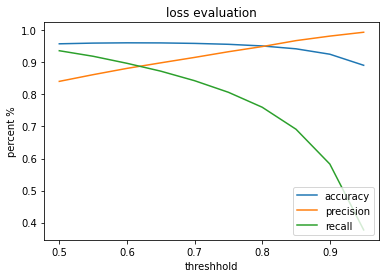

In [0]:
plt.plot(percents, train_acc, label = "accuracy")
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshhold")
plt.ylabel("percent %")
plt.title("loss evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

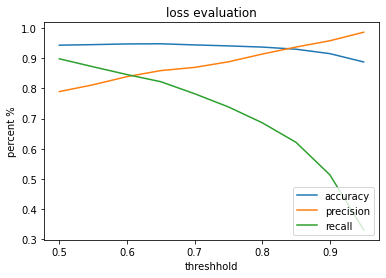

In [0]:
plt.plot(percents, val_acc, label = "accuracy")
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("loss evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

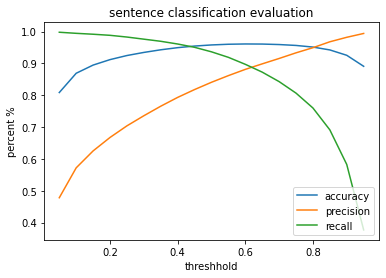

In [0]:
plt.plot(percents, train_acc, label = "accuracy")
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

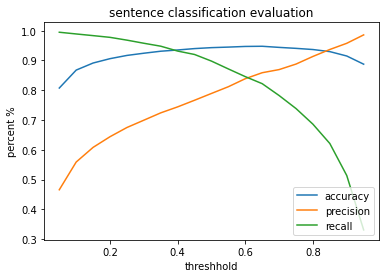

In [0]:
plt.plot(percents, val_acc, label = "accuracy")
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

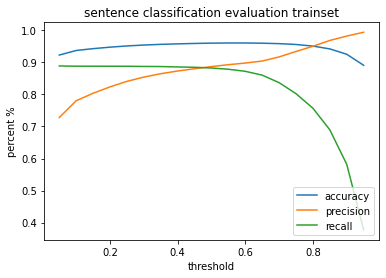

In [0]:
plt.plot(percents, train_acc, label = "accuracy") #0.1
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation trainset", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

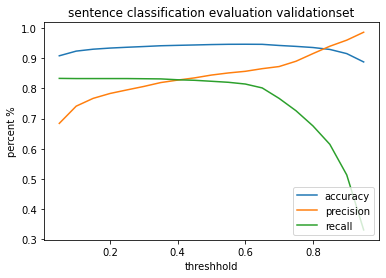

In [0]:
plt.plot(percents, val_acc, label = "accuracy") #0.1
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation validationset", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

In [0]:
def non_maximum_suppression(tensor, percent):
    """choose predicted lines by highest propability. 
    Lines who overlap a actual choosen line by percent or higher will delete."""
    
    for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
            if(tensor[i,j,0].item() < 0.5):
                tensor[i,j,0] = torch.tensor(0)
        found = []
        while(True):
            maximum = 0
            index = 0
            for j in range(tensor.size(1)):
                if(tensor[i,j,0].item() > maximum and j not in found):
                    maximum = tensor[i,j,0].item()
                    index = j

            if(maximum == 0):
                break

            found.append(index)
            tensor[i,index,0] = torch.tensor(1)
            
            for j in range(tensor.size(1)):
                if(j != index and tensor[i,j,0] >= 0.5):
                    x_y_max = calc_x_y(index, tensor[i, index])
                    x_y_other = calc_x_y(j, tensor[i, j])
                    box1 = calc_box(x_y_max)
                    box2 = calc_box(x_y_other)
                    if(calc_iou(box1, box2) > percent):
                        tensor[i,j,0] = 0

In [0]:
device = "cuda" #0.6 treshold, 0.8 iou 95,84,84  #0.5 treshold, 0.8 iou 95,84,84
val_list = []
train_list = []
percents = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.90]
for percent in percents:
    val_list.append(validate(test_data, model, device, 1, percent))
    train_list.append(validate(train_data, model, device, 1, percent))

loss 2.8 IOU 0.74
loss 3.7 IOU 0.76
loss 2.5 IOU 0.78
loss 3.4 IOU 0.77
loss 3.9 IOU 0.78
loss 2.4 IOU 0.79
loss 2.2 IOU 0.79
loss 2.6 IOU 0.8
loss 4.3 IOU 0.71
loss 3.3 IOU 0.76
loss 3.7 IOU 0.78
loss 3.4 IOU 0.75
loss 2.1 IOU 0.8
avg. loss 3.1 avg. IOU 0.77 avg. acc 0.95 avg. prec 0.85 avg. rec 0.82
loss 2.3 IOU 0.78
loss 2.8 IOU 0.78
loss 2.3 IOU 0.81
loss 1.4 IOU 0.78
loss 1.5 IOU 0.81
loss 2.4 IOU 0.77
loss 2.4 IOU 0.8
loss 2.0 IOU 0.79
loss 1.7 IOU 0.8
loss 2.3 IOU 0.76
loss 1.4 IOU 0.8
loss 3.1 IOU 0.76
loss 2.3 IOU 0.79
loss 3.2 IOU 0.8
loss 2.6 IOU 0.8
loss 1.5 IOU 0.77
loss 2.5 IOU 0.78
loss 2.2 IOU 0.81
loss 3.2 IOU 0.81
loss 2.4 IOU 0.82
loss 1.7 IOU 0.77
loss 1.9 IOU 0.78
loss 2.4 IOU 0.79
loss 1.4 IOU 0.77
loss 2.3 IOU 0.78
loss 2.2 IOU 0.78
loss 3.0 IOU 0.8
loss 2.5 IOU 0.8
loss 2.2 IOU 0.79
loss 3.1 IOU 0.79
loss 1.8 IOU 0.8
loss 1.8 IOU 0.71
loss 2.5 IOU 0.77
loss 2.0 IOU 0.81
loss 2.4 IOU 0.81
loss 2.1 IOU 0.79
loss 1.3 IOU 0.82
loss 2.2 IOU 0.82
loss 1.7 IOU 0.82
los

In [0]:
train_loss = [lis[0] for lis in train_list]
train_iou = [lis[1] for lis in train_list]
train_acc = [lis[2] for lis in train_list]
train_prec = [lis[3] for lis in train_list]
train_rec = [lis[4] for lis in train_list]
val_loss = [lis[0] for lis in val_list]
val_iou = [lis[1] for lis in val_list]
val_acc = [lis[2] for lis in val_list]
val_prec = [lis[3] for lis in val_list]
val_rec = [lis[4] for lis in val_list]

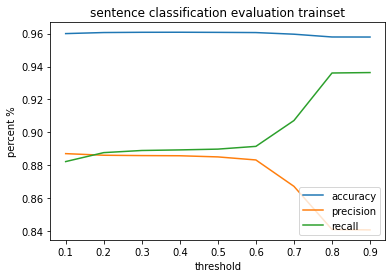

In [0]:
plt.plot(percents, train_acc, label = "accuracy") #0.1
plt.plot(percents, train_prec, label = "precision")
plt.plot(percents, train_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation trainset", fontdict = None)
plt.legend(loc = "lower right")
plt.show()

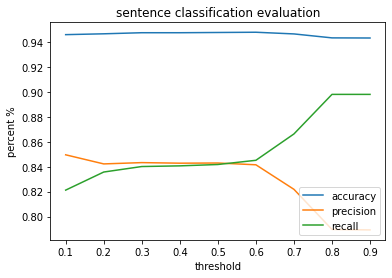

In [0]:
plt.plot(percents, val_acc, label = "accuracy")
plt.plot(percents, val_prec, label = "precision")
plt.plot(percents, val_rec, label = "recall")
plt.xlabel("threshold")
plt.ylabel("percent %")
plt.title("sentence classification evaluation", fontdict = None)
plt.legend(loc = "lower right")
plt.show()